# Example of confidence interval computation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import zfit
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests import ConfidenceInterval
from hepstats.hypotests.parameters import POIarray

from utils import one_minus_cl_plot, pltdist

/Users/matthieumarinangeli/anaconda3/envs/tfn/lib/python3.7/site-packages/zfit-0.1.dev1243+g3358391.d20191114-py3.7.egg/zfit/util/execution.py:61: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
plt.rcParams['figure.figsize'] = (9,8)
plt.rcParams['font.size'] = 16

### Fit of a Gaussian signal over an exponential background:

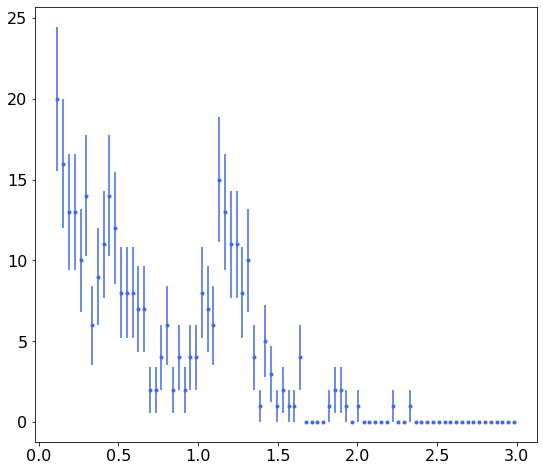

In [3]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 80)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

pltdist(data, bins=80, bounds=bounds)

In [4]:
obs = zfit.Space('x', limits=bounds)

In [5]:
mean = zfit.Parameter("mean", 1.2, 0.5, 2.0)
sigma = zfit.Parameter("sigma", 0.1, 0.02, 0.2)
lambda_ = zfit.Parameter("lambda",-2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", 20., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [6]:
signal = Nsig * zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
background =  Nbkg * zfit.pdf.Exponential(obs=obs, lambda_=lambda_)
tot_model = signal + background

In [7]:
# Create the negative log likelihood
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=tot_model, data=data_) 

In [8]:
# Instantiate a minuit minimizer
minimizer = Minuit()

In [9]:
# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


FCN = -1430.5234282753304 
 TOTAL NCALL = 147 
 NCALLS = 147 
 
 
 EDM = 2.1872156563911315e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Nbkg,246.919,17.469,,,0,358.6,No
1,Nsig,79.1084,11.7657,,,-20,326,No
2,mean,1.19825,0.0173342,,,0.5,2,No
3,sigma,0.11252,0.0167949,,,0.02,0.2,No
4,lambda,-1.98064,0.1573,,,-4,-1,No


In [10]:
def plotfitresult(pdf, bounds, nbins, data):
    x = np.linspace(*bounds, num=1000)
    pdf = zfit.run(tot_model.pdf(x, norm_range=bounds)* tot_model.get_yield())
    _ = plt.plot(x, ((bounds[1] - bounds[0])/nbins)*(pdf), "-r", label="fit result")

Text(0, 0.5, 'number of events')

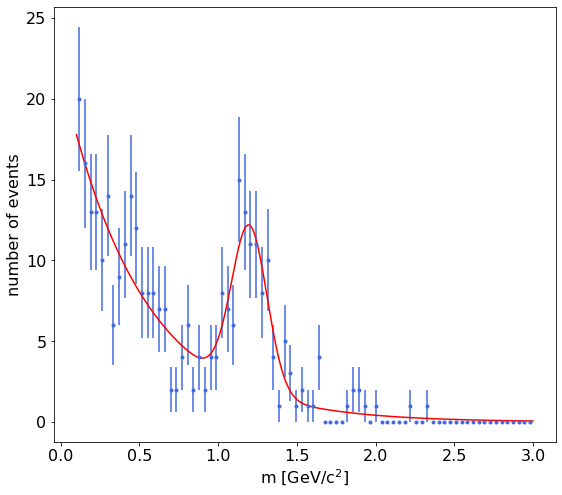

In [11]:
nbins = 80
pltdist(data, nbins, bounds)
plotfitresult(tot_model, bounds, nbins)
plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")

### Confidence interval

We want to compute the confidence interval of the mean of the Gaussian at 68% confidence level.

In [12]:
# instantation of the calculator
calculator = AsymptoticCalculator(nll, minimizer)
calculator.bestfit = minimum #optionnal

In [13]:
# parameter of interest of the null hypothesis
poinull = POIarray(mean, np.linspace(1.15, 1.26, 100))

In [14]:
# instantation of the discovery test
ci = ConfidenceInterval(calculator, poinull)

In [15]:
ci.interval();


Confidence interval on mean:
	1.181037134504574 < mean < 1.215670118721637 at 68.0% C.L.


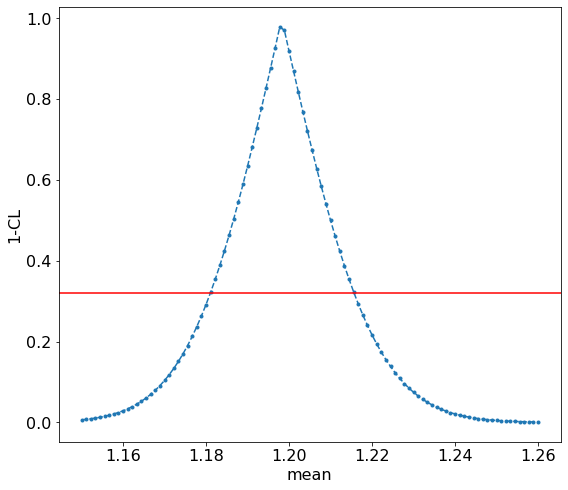

In [16]:
f = plt.figure(figsize=(9, 8))
one_minus_cl_plot(poinull.values, ci.pvalues())
plt.xlabel("mean")
f.savefig("asy_ci.png")